In [273]:
# coding: utf-8
"""
AutoEncoder実験用のコード
"""
import os
import random

import chainer
from chainer.dataset import convert
from sklearn.datasets import load_digits, fetch_mldata
from sklearn.cross_validation import train_test_split
from sklearn.cluster import KMeans
from sklearn.metrics import v_measure_score
from mnist import MNIST
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')

from sampleAE import AE
from sampleVAE import VAE
from sampleCVAE import CVAE

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 関数の定義

In [274]:
def train_model(model_nm, input_size, hidden_size, z_size, label_size, minibatch_size, epoch_num, X_train, output):

    if model_nm == 'AE':
        model = AE(input_size, z_size, hidden_size)
    elif model_nm == 'VAE':
        model = VAE(input_size, z_size, hidden_size)
    elif model_nm == 'CVAE':
        model = CVAE(input_size, z_size, hidden_size, label_size)
    else:
        print('incorrect MODEL_NM')
        return

    # Setup an optimizer
    optimizer = chainer.optimizers.Adam()
    optimizer.setup(model)

    train_iter = chainer.iterators.SerialIterator(X_train, minibatch_size)

    for epoch in range(0, epoch_num):
        sum_loss = 0
        sum_rec_loss = 0

        batch = train_iter.next()
        # Update model based on the loss function
        # defined by model.get_loss_func()
        if model_nm == 'AE':
            x_array = convert.concat_examples(batch)
            x = chainer.Variable(x_array)
            optimizer.update(model.get_loss_func(), x)
        elif model_nm == 'VAE':
            x_array = convert.concat_examples(batch)
            x = chainer.Variable(x_array)
            optimizer.update(model.get_loss_func(C=0.1, k=5), x)
        elif model_nm == 'CVAE':
            x_array, t_array = convert.concat_examples(batch)
            x = chainer.Variable(x_array)
            t = chainer.Variable(t_array)
            optimizer.update(model.get_loss_func(C=0.1, k=5), x, t)

        sum_loss += float(model.loss.data) * len(x.data)
        sum_rec_loss += float(model.rec_loss.data) * len(x.data)

    chainer.serializers.save_npz(output, model)
    print('train mean loss={}, mean reconstruction loss={}'.format(sum_loss / train_count, sum_rec_loss / train_count))
    
def test_plot(model_nm, model, X_test, y_test):
    colors_dict = {
        0: '#ff2800',
        1: '#faf500',
        2: '#35a16b',
        3: '#0041ff',
        4: '#66ccff',
        5: '#ff99a0',
        6: '#ff9900',
        7: '#9a0079',
        8: '#663300',
        9: '#000000'
    }
    
    train_iter = chainer.iterators.SerialIterator(X_test, len(X_test), repeat=False, shuffle=False)

    with chainer.using_config('train', False), chainer.no_backprop_mode():
        batch = train_iter.next()
        if model_nm == 'AE' or model_nm=='VAE':
            x_array = convert.concat_examples(batch)
            x = chainer.Variable(x_array)
            x_mu, _ = model.encode(x)
        elif model_nm == 'CVAE':
            x_array, t_array = convert.concat_examples(batch)
            x = chainer.Variable(x_array)
            t = chainer.Variable(t_array)
            x_mu, _ = model.encode(x, t)
            
    data_dict = {}
    for x, y in zip(x_mu.data, y_test):
        if y in data_dict:
            data_dict[y].append(x)
        else:
            data_dict[y] = [x]
    for y in range(0, 10):
        data = data_dict[y]
        xs = [row[0] for row in data]
        ys = [row[1] for row in data]
        plt.scatter(xs, ys, c=colors_dict[y], label=y, alpha=0.6)
    plt.title(model_nm)
    plt.legend()
    plt.show()
    
def test_kmeans(model_nm, model, X_test, y_test):
    
    train_iter = chainer.iterators.SerialIterator(X_test, len(X_test), repeat=False, shuffle=False)

    with chainer.using_config('train', False), chainer.no_backprop_mode():
        batch = train_iter.next()
        if model_nm == 'AE':
            x_array = convert.concat_examples(batch)
            x = chainer.Variable(x_array)
            x_mu, _ = model.encode(x)
        elif model_nm == 'VAE':
            x_array = convert.concat_examples(batch)
            x = chainer.Variable(x_array)
            x_mu, _ = model.encode(x)
        elif model_nm == 'CVAE':
            x_array, t_array = convert.concat_examples(batch)
            x = chainer.Variable(x_array)
            t = chainer.Variable(t_array)
            x_mu, _ = model.encode(x, t)
        
    predicts = KMeans(n_clusters=10).fit_predict(x_mu.data)
    
    return v_measure_score(y_test, predicts)


def test_decode(model, x, label, output):
    with chainer.using_config('train', False), chainer.no_backprop_mode():
        x_v = chainer.Variable(x)
        if label is None:
            y_v = model(x_v)
        else:
            label_v = chainer.Variable(label)
            y_v = model(x_v, label_v)
    print('出力')
    pixels = (y_v.data * 256).reshape((28, 28))
    plt.imshow(pixels, cmap='gray')
    plt.show()
    plt.imsave(output, pixels, cmap='gray')
    
def test_x_to_y(model, x, y, step = 20):
    with chainer.using_config('train', False), chainer.no_backprop_mode():
        x_v = chainer.Variable(x)
        y_v = chainer.Variable(y)
        z_x, _ = model.encode(x_v)
        z_y, _ = model.encode(y_v)

        for i in range(step+1):
            z = ((step-i) * z_x + i * z_y) / step
            t = model.decode(z)
            print('{0}番目'.format(i))
            pixels = (t.data * 256).reshape((28, 28))
            plt.imshow(pixels, cmap='gray')
            plt.imsave('./tmp{0}.png'.format(str(i).zfill(2)), pixels, cmap='gray')
            plt.show()

# 学習データの作成

In [120]:
# Load the MNIST dataset
mndata = MNIST('./files/mldata/')

trains = mndata.load_training()
X_train = np.array(trains[0], dtype='float32') / 255
y_train = np.array(trains[1], dtype='int32')

tests = mndata.load_training()

X_test = np.array(tests[0], dtype='float32') / 255
y_test = np.array(tests[1], dtype='int32')
Xy_test = random.sample([(x, y) for x, y in zip(X_test, y_test)], 2000)
X_test = np.array([row[0] for row in Xy_test], dtype='float32')
y_test = np.array([row[1] for row in Xy_test], dtype='int32')

train_count = len(X_train)

y_train_half = np.concatenate([y_train[0:30000], np.ones(train_count-30000)*-1]).astype('int32')

Xy_train = [(x, y) for x, y in zip(X_train, y_train_half)]
Xy_test = [(x, -1) for x, y in zip(X_test, y_test)]

# モデルの作成

In [ ]:
EPOCH_NUM = 1000
INPUT_SIZE = 784
HIDDEN_SIZE = 128
MINIBATCH_SIZE = 100
LABEL_SIZE = 10

MODEL_NM_AE = 'AE'
MODEL_NM_VAE = 'VAE'
MODEL_NM_CVAE = 'CVAE'

scores = {}

for Z_SIZE in [4, 16, 64]:
    MODEL_PATH_AE = './files/AE_{0}_{1}.model'.format(EPOCH_NUM, Z_SIZE)
    MODEL_PATH_VAE = './files/VAE_{0}_{1}.model'.format(EPOCH_NUM, Z_SIZE)
    MODEL_PATH_CVAE = './files/CVAE_{0}_{1}.model'.format(EPOCH_NUM, Z_SIZE)

    train_model(
        model_nm=MODEL_NM_AE,
        input_size=INPUT_SIZE,
        hidden_size=HIDDEN_SIZE,
        z_size=Z_SIZE,
        label_size=None,
        minibatch_size=MINIBATCH_SIZE,
        epoch_num=EPOCH_NUM,
        X_train=X_train,
        output=MODEL_PATH_AE
    )
    
    train_model(
        model_nm=MODEL_NM_VAE,
        input_size=INPUT_SIZE,
        hidden_size=HIDDEN_SIZE,
        z_size=Z_SIZE,
        label_size=None,
        minibatch_size=MINIBATCH_SIZE,
        epoch_num=EPOCH_NUM,
        X_train=X_train,
        output=MODEL_PATH_VAE
    )
    
    train_model(
        model_nm=MODEL_NM_CVAE,
        input_size=INPUT_SIZE,
        hidden_size=HIDDEN_SIZE,
        z_size=Z_SIZE,
        label_size=LABEL_SIZE,
        minibatch_size=MINIBATCH_SIZE,
        epoch_num=EPOCH_NUM,
        X_train=Xy_train,
        output=MODEL_PATH_CVAE
    )

# 実験1（復元）

入力


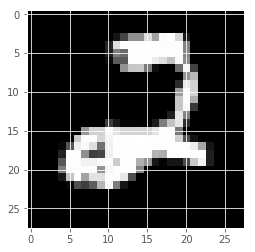

*******Z_SIZE: 4*******
-------AE-------
出力


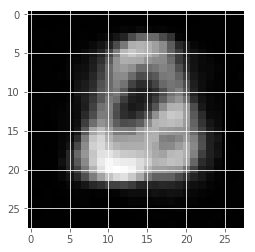

-------VAE-------
出力


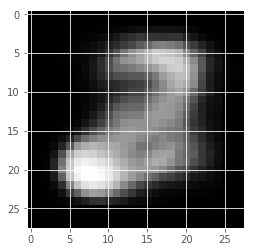

-------CVAE-------
出力


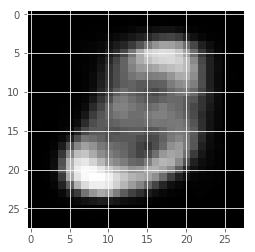

出力


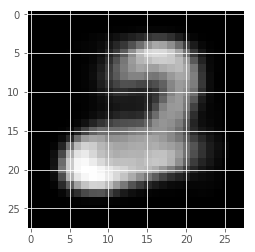

出力


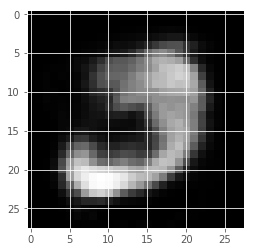

*******Z_SIZE: 16*******
-------AE-------
出力


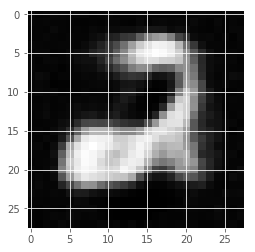

-------VAE-------
出力


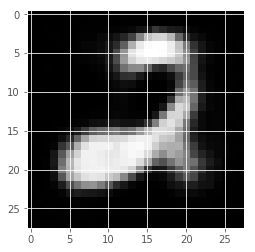

-------CVAE-------
出力


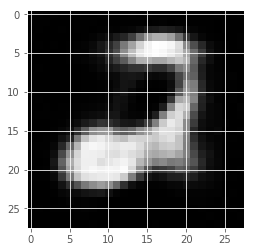

出力


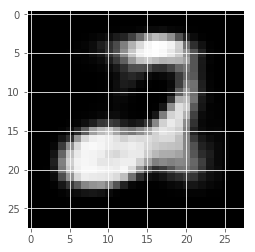

出力


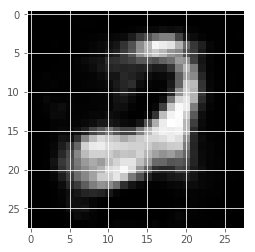

*******Z_SIZE: 64*******
-------AE-------
出力


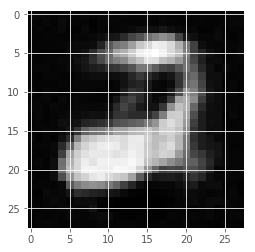

-------VAE-------
出力


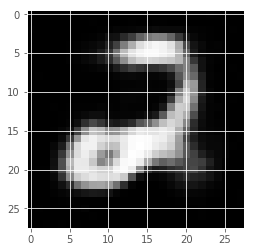

-------CVAE-------
出力


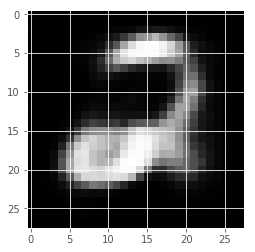

出力


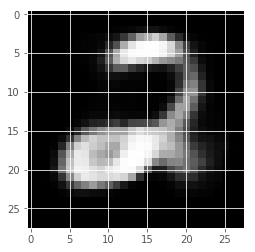

出力


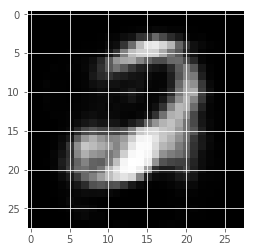

In [280]:
num = 100
number = 2
cvae_labels = [-1, number, 7]
#num = 1
#number = 4
#cvae_labels = [-1, number, 9]

print('入力')
pixels = (X_test[num] * 256).reshape((28, 28))
plt.imshow(pixels, cmap='gray')
plt.show()

for Z_SIZE in [4, 16, 64]:
    print('*******Z_SIZE: {0}*******'.format(Z_SIZE))
    MODEL_PATH_AE = './files/AE_1000_{0}.model'.format(Z_SIZE)
    MODEL_PATH_VAE = './files/VAE_1000_{0}.model'.format(Z_SIZE)
    MODEL_PATH_CVAE = './files/CVAE_1000_{0}.model'.format(Z_SIZE)
    LABEL_SIZE = 10
    INPUT_SIZE = 784
    HIDDEN_SIZE = 128


    ae_model = AE(INPUT_SIZE, Z_SIZE, HIDDEN_SIZE)
    vae_model = VAE(INPUT_SIZE, Z_SIZE, HIDDEN_SIZE)
    cvae_model = CVAE(INPUT_SIZE, Z_SIZE, HIDDEN_SIZE, LABEL_SIZE)

    chainer.serializers.load_npz(MODEL_PATH_AE, ae_model)
    chainer.serializers.load_npz(MODEL_PATH_VAE, vae_model)
    chainer.serializers.load_npz(MODEL_PATH_CVAE, cvae_model)

    print('-------AE-------')
    test_decode(ae_model, X_test[[num]], None, './AE_{0}_{1}.png'.format(Z_SIZE, number))
    print('-------VAE-------')
    test_decode(vae_model, X_test[[num]], None, './VAE_{0}_{1}.png'.format(Z_SIZE, number))
    print('-------CVAE-------')
    for cvae_label in cvae_labels:
        test_decode(cvae_model, X_test[[num]], np.array([cvae_label], dtype='int32'), './CVAE_{0}_{1}_{2}.png'.format(Z_SIZE, number, cvae_label))

# 実験2（連続変化）

*******Z_SIZE: 4*******
---画像x---


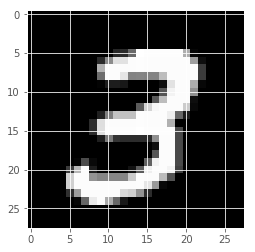

---画像y---


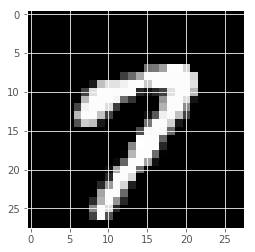

0番目


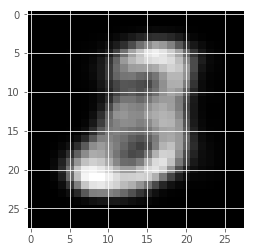

1番目


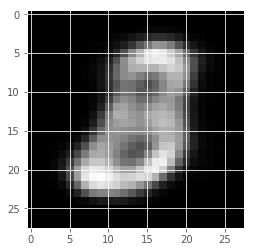

2番目


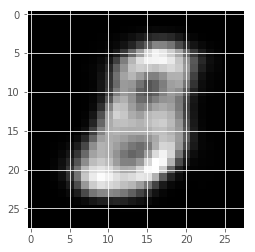

3番目


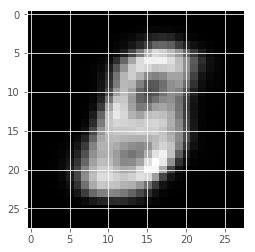

4番目


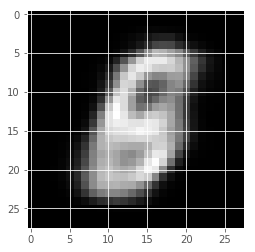

5番目


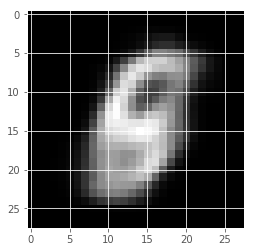

6番目


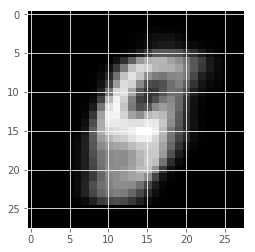

7番目


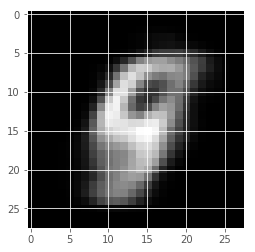

8番目


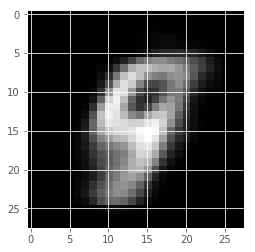

9番目


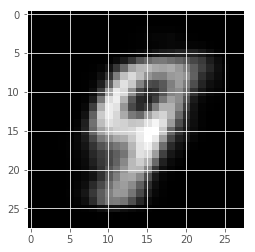

10番目


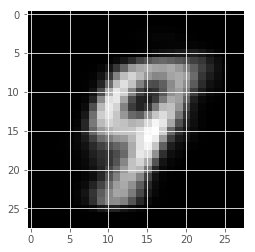

11番目


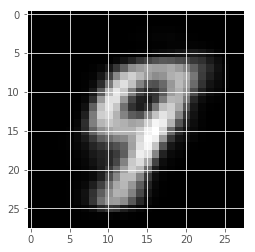

12番目


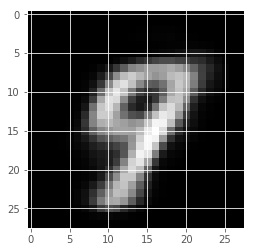

13番目


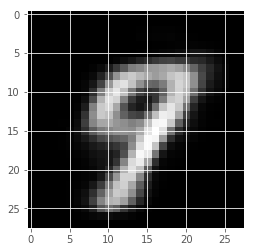

14番目


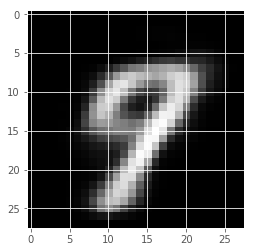

15番目


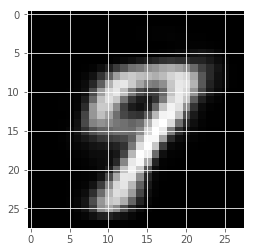

16番目


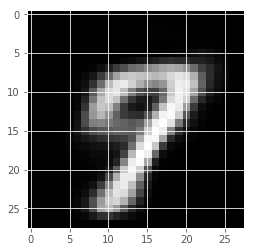

17番目


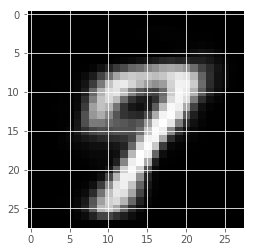

18番目


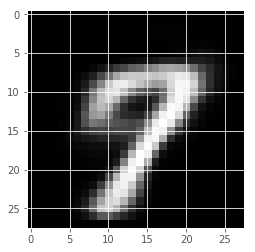

19番目


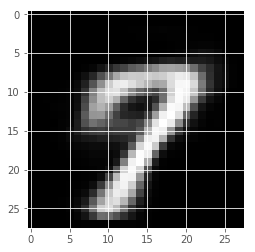

20番目


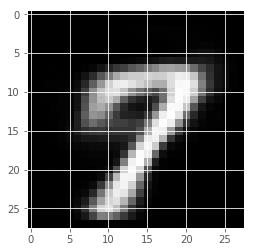

*******Z_SIZE: 16*******
---画像x---


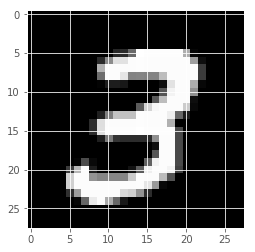

---画像y---


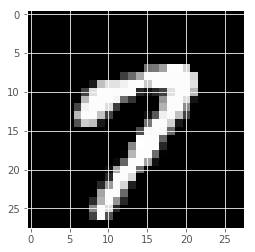

0番目


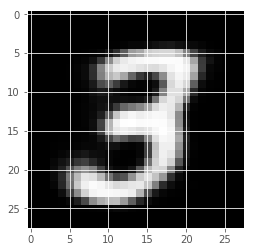

1番目


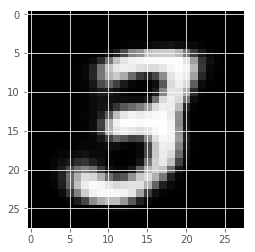

2番目


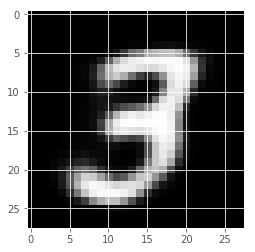

3番目


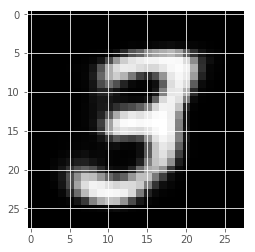

4番目


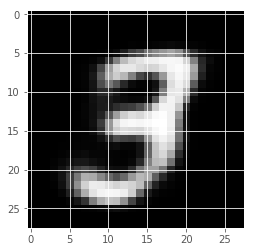

5番目


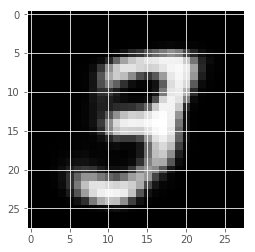

6番目


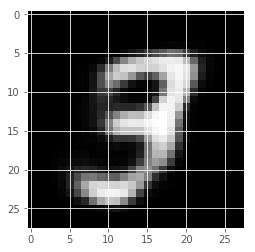

7番目


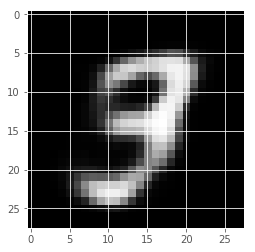

8番目


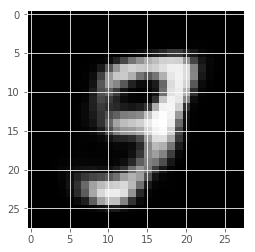

9番目


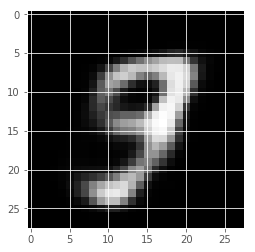

10番目


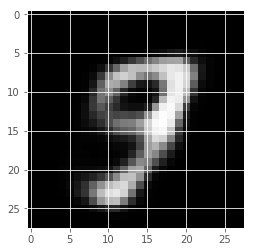

11番目


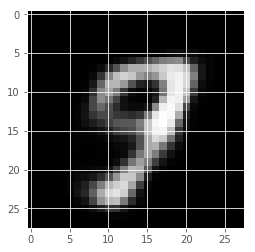

12番目


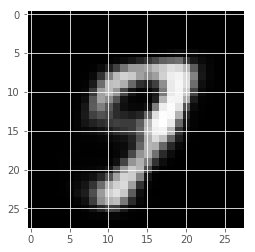

13番目


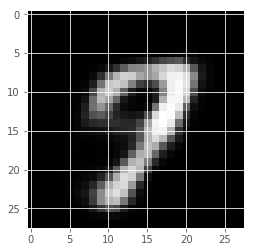

14番目


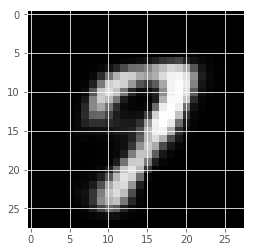

15番目


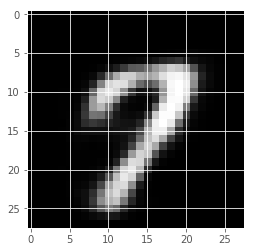

16番目


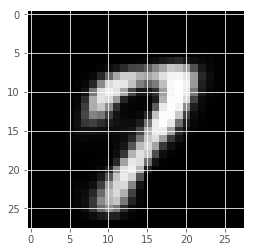

17番目


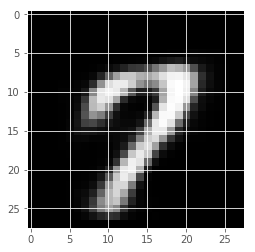

18番目


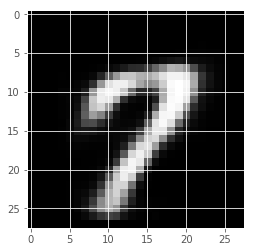

19番目


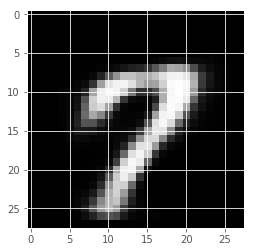

20番目


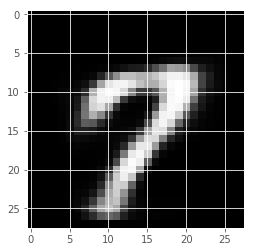

*******Z_SIZE: 64*******
---画像x---


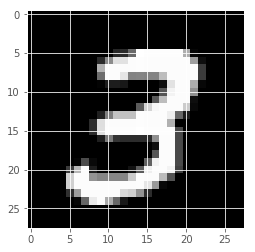

---画像y---


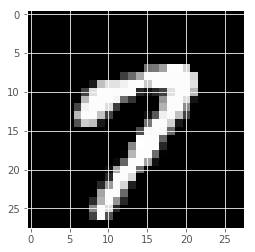

0番目


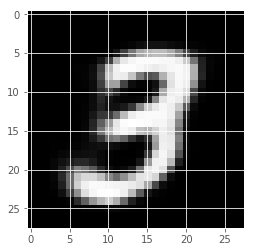

1番目


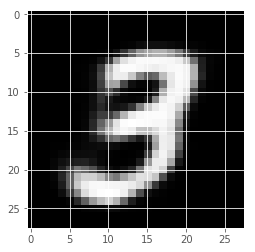

2番目


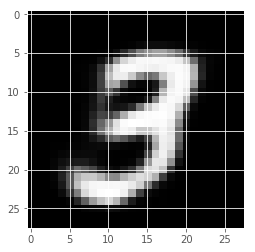

3番目


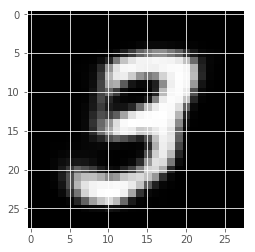

4番目


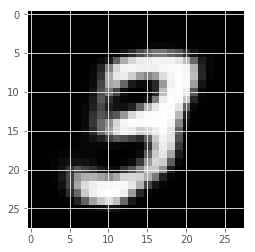

5番目


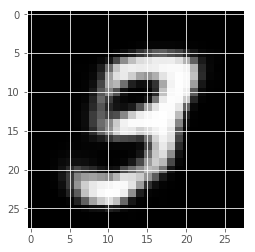

6番目


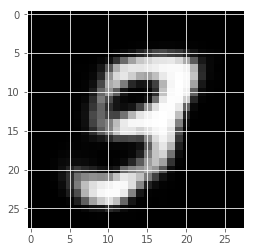

7番目


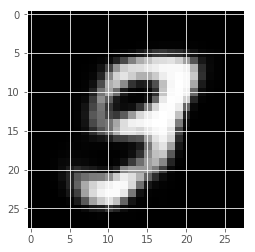

8番目


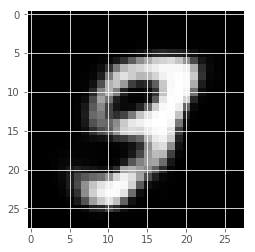

9番目


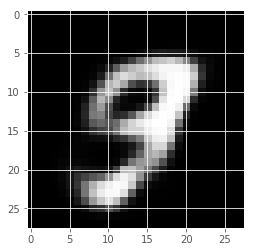

10番目


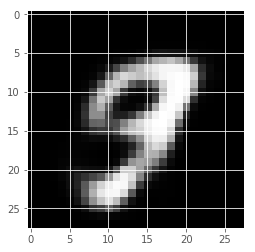

11番目


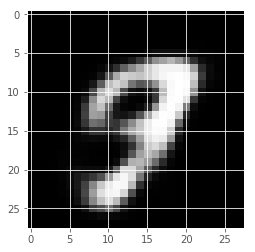

12番目


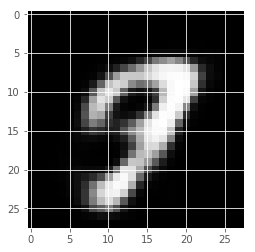

13番目


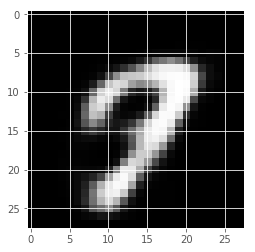

14番目


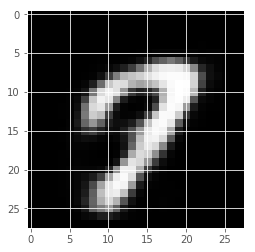

15番目


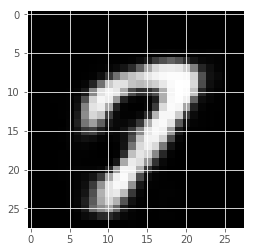

16番目


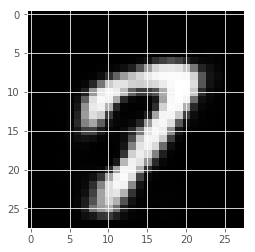

17番目


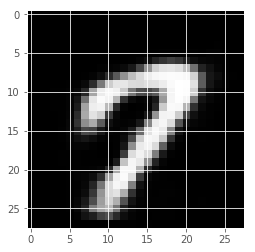

18番目


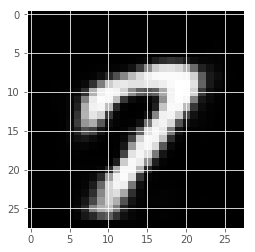

19番目


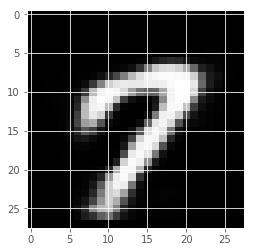

20番目


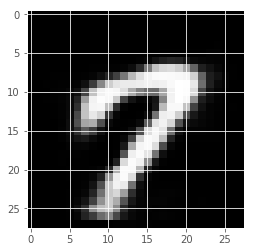

In [272]:
num1 = 7
num2 = 15
#num1 = 3
#num2 = 1

INPUT_SIZE = 784
HIDDEN_SIZE = 128

for Z_SIZE in [4, 16, 64]:
    print('*******Z_SIZE: {0}*******'.format(Z_SIZE))
    MODEL_PATH_VAE = './files/VAE_1000_{0}.model'.format(Z_SIZE)

    vae_model = VAE(INPUT_SIZE, Z_SIZE, HIDDEN_SIZE)
    chainer.serializers.load_npz(MODEL_PATH_VAE, vae_model)

    x = X_train[[num1]]
    y = X_train[[num2]]

    print('---画像x---')
    pixels = (x * 256).reshape((28, 28))
    plt.imshow(pixels, cmap='gray')
    plt.show()

    print('---画像y---')
    pixels = (y * 256).reshape((28, 28))
    plt.imshow(pixels, cmap='gray')
    plt.show()

    test_x_to_y(vae_model, x, y)

# 実験3（プロット）

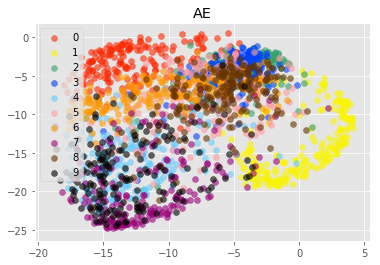

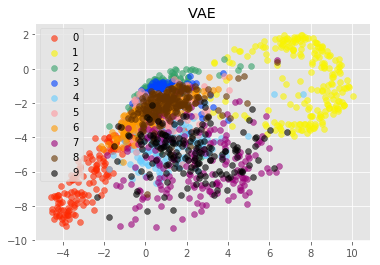

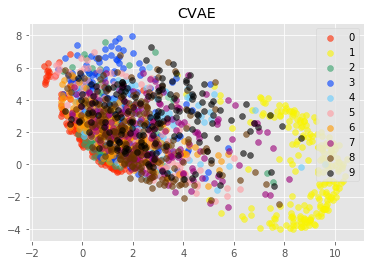

In [271]:
EPOCH_NUM = 1000
INPUT_SIZE = 784
HIDDEN_SIZE = 128
Z_SIZE = 2
MINIBATCH_SIZE = 100
LABEL_SIZE = 10

MODEL_NM_AE = 'AE'
MODEL_NM_VAE = 'VAE'
MODEL_NM_CVAE = 'CVAE'

MODEL_PATH_AE = './files/AE_1000_2.model'
MODEL_PATH_VAE = './files/VAE_1000_2.model'
MODEL_PATH_CVAE = './files/CVAE_1000_2.model'

ae_model = AE(INPUT_SIZE, Z_SIZE, HIDDEN_SIZE)
vae_model = VAE(INPUT_SIZE, Z_SIZE, HIDDEN_SIZE)
cvae_model = CVAE(INPUT_SIZE, Z_SIZE, HIDDEN_SIZE, LABEL_SIZE)

chainer.serializers.load_npz(MODEL_PATH_AE, ae_model)
chainer.serializers.load_npz(MODEL_PATH_VAE, vae_model)
chainer.serializers.load_npz(MODEL_PATH_CVAE, cvae_model)

test_plot(MODEL_NM_AE, ae_model, X_test, y_test)
test_plot(MODEL_NM_VAE, vae_model, X_test, y_test)
test_plot(MODEL_NM_CVAE, cvae_model, Xy_test, y_test)

# 実験4（クラスタリング）

train mean loss=9.011354995891451e-07, mean reconstruction loss=9.011354995891451e-07
train mean loss=0.2834436289469401, mean reconstruction loss=0.2806903839111328
train mean loss=0.29831881205240884, mean reconstruction loss=0.2962603759765625


No handles with labels found to put in legend.


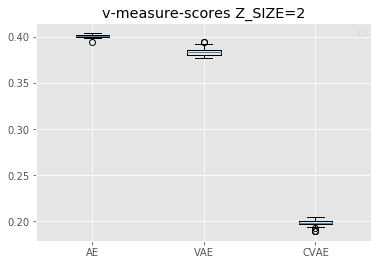

train mean loss=7.134973808812598e-07, mean reconstruction loss=7.134973808812598e-07
train mean loss=0.2439881388346354, mean reconstruction loss=0.23975672403971354
train mean loss=0.23456652323404947, mean reconstruction loss=0.23062243143717448


No handles with labels found to put in legend.


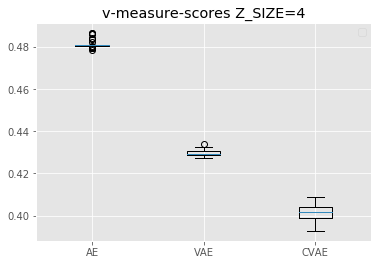

train mean loss=4.268377961125225e-07, mean reconstruction loss=4.268377961125225e-07
train mean loss=0.18233131408691405, mean reconstruction loss=0.17444637298583984
train mean loss=0.19100220998128256, mean reconstruction loss=0.18386531829833985


No handles with labels found to put in legend.


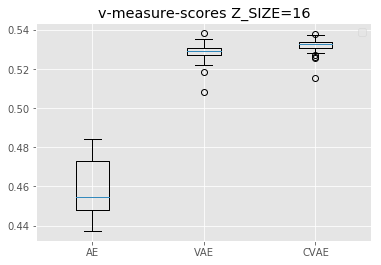

train mean loss=4.494325063812236e-07, mean reconstruction loss=4.494325063812236e-07
train mean loss=0.16727345784505207, mean reconstruction loss=0.1548500442504883
train mean loss=0.18303569793701172, mean reconstruction loss=0.17167686462402343


No handles with labels found to put in legend.


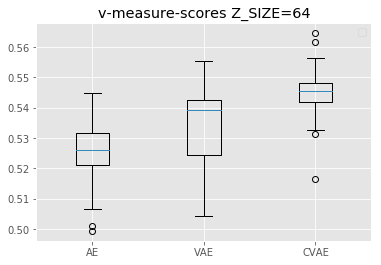

In [232]:
EPOCH_NUM = 1000
INPUT_SIZE = 784
HIDDEN_SIZE = 128
MINIBATCH_SIZE = 100
LABEL_SIZE = 10

MODEL_NM_AE = 'AE'
MODEL_NM_VAE = 'VAE'
MODEL_NM_CVAE = 'CVAE'

scores = {}

for Z_SIZE in [2, 4, 16, 64]:
    MODEL_PATH_AE = './files/AE_{0}_{1}.model'.format(EPOCH_NUM, Z_SIZE)
    MODEL_PATH_VAE = './files/VAE_{0}_{1}.model'.format(EPOCH_NUM, Z_SIZE)
    MODEL_PATH_CVAE = './files/CVAE_{0}_{1}.model'.format(EPOCH_NUM, Z_SIZE)
    
    ae_model = AE(INPUT_SIZE, Z_SIZE, HIDDEN_SIZE)
    vae_model = VAE(INPUT_SIZE, Z_SIZE, HIDDEN_SIZE)
    cvae_model = CVAE(INPUT_SIZE, Z_SIZE, HIDDEN_SIZE, LABEL_SIZE)
    chainer.serializers.load_npz(MODEL_PATH_AE, ae_model)
    chainer.serializers.load_npz(MODEL_PATH_VAE, vae_model)
    chainer.serializers.load_npz(MODEL_PATH_CVAE, cvae_model)
    
    score_ae = []
    score_vae = []
    score_cvae = []
    for _ in range(50):
        score_ae.append(test_kmeans(MODEL_NM_AE, ae_model, X_test, y_test))
        score_vae.append(test_kmeans(MODEL_NM_VAE, vae_model, X_test, y_test))
        score_cvae.append(test_kmeans(MODEL_NM_CVAE, cvae_model, Xy_test, y_test))
    scores[Z_SIZE] = {
        MODEL_NM_AE: score_ae,
        MODEL_NM_VAE: score_vae,
        MODEL_NM_CVAE: score_cvae
    }
    fig = plt.figure()
    ax = fig.add_subplot(111)

    bp = ax.boxplot((score_ae, score_vae, score_cvae))
    ax.set_xticklabels(['AE', 'VAE', 'CVAE'])
    plt.legend()
    plt.title('v-measure-scores Z_SIZE={0}'.format(Z_SIZE))
    plt.show()